# Mass of the Exoplanet using emcee

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
from scipy.optimize import minimize

Importing the radial velocity data

In [2]:
# Retrieving data
time1, rv, rve = np.loadtxt('homework_rv.txt', usecols=(0,1,2), unpack=True)
time = time1*24*60*60

Text(0, 0.5, 'Radial Velocity')

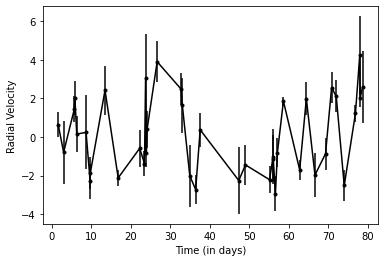

In [3]:
# Visulizing the data
plt.errorbar(time1, rv, yerr=rve, fmt='k.-')
plt.xlabel('Time (in days)')
plt.ylabel('Radial Velocity')

### The trick is to treat $\nu$ as a fixed parameter

In [4]:
# Defining some of the constants/parameters of the system
mp = 4*5.972e+24
Ms = 0.65*1.989e+30
incli = np.pi/2
nu = (2*np.pi)/(6.5*24*60*60)
t0 = 0
V0 = 0
G = 6.6743e-11

In [5]:
def mass(Aa, Bb):
    global incli, Ms, nu, G
    KK = np.sqrt(Aa**2 + Bb**2)
    KK1 = KK/np.sin(incli)
    mm = KK1*Ms**(2/3)/(nu**(1/3) * G**(1/3))
    return mm

In [6]:
def ftheta(theta):
    global time, nu
    t1 = time
    f1 = theta[0]*np.cos(nu*t1) + theta[1]*np.sin(nu*t1) + theta[2]
    return f1

def log_likelihood(theta):
    global time, rv, rve
    chi = ((rv - ftheta(theta))**2)/rve**2
    chi2 = 0.5*np.sum(chi)
    err = np.sum(np.log(rve))
    ll = -0.5*len(time)*np.log(2*np.pi) - err - chi2
    return ll

def neg_likelihood(theta):
    xx = -log_likelihood(theta)
    return xx

def log_prior(theta):
    global time
    ss = 100
    logs = np.log(ss*ss*ss)
    bb = - (theta[0]**2)/(2*ss**2) - (theta[1]**2)/(2*ss**2) - (theta[2]**2)/(2*ss**2)
    lp = -1.5*np.log(2*np.pi) - logs + bb
    return lp

def log_prob(theta):
    priors = log_prior(theta)
    likelihood = log_likelihood(theta)
    lpp = priors + likelihood
    return lpp

## Parameter estimation using scipy.minimize

First of all, we want to use scipy.optimize.minimize to find ML estimates of the parameters, which, later, we can use as initial guess in MCMC calculations.

In [7]:
#initial = np.array([1, 1, 1, nu])
A11 = np.zeros(1000)
B11 = np.zeros(1000)
C11 = np.zeros(1000)
for i in range(1000):
    initial = np.array([1,1,1])*0.1*np.random.randn(3)
    soln1 = minimize(neg_likelihood, initial)
    aa, bb, cc = soln1.x
    A11[i] = aa
    B11[i] = bb
    C11[i] = cc

ML Analysis:
------------
Estimate of mass: 4.654953756847168 M_earth.
Standard deviation in the estimate: 1.2106369356053073e-07 M_earth.


Text(0, 0.5, 'Counts')

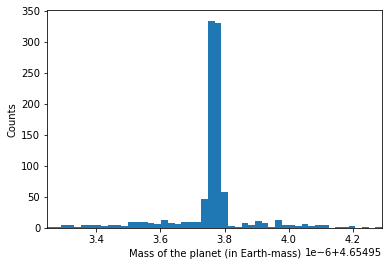

In [8]:
#A11, B11, C11, nu11 = soln.x
mass1_ml = mass(A11, B11)
mass_ml = mass1_ml/5.972e+24
print('ML Analysis:')
print('------------')
print('Estimate of mass: ' + str(np.mean(mass_ml)) + ' M_earth.')
print('Standard deviation in the estimate: ' + str(np.std(mass_ml)) + ' M_earth.')

plt.hist(mass_ml, bins=50)
plt.xlim([np.min(mass_ml), np.max(mass_ml)])
plt.xlabel('Mass of the planet (in Earth-mass)')
plt.ylabel('Counts')

It's working! But let's find least square estimates as well!

## Least square estimates

In [9]:
V = np.diag(rve)
V1 = np.linalg.inv(V)

M11 = np.vstack((np.cos(nu*time), np.sin(nu*time)))
M = np.vstack((M11, np.ones(len(time)))).T
MT = M.T

F1 = MT.dot(V1).dot(M)
F2 = np.linalg.inv(F1)

FF = MT.dot(V1).dot(M)
cov = np.linalg.inv(FF)
theta_theoretical = cov.dot(MT).dot(V1).dot(rv)

AA_the = np.random.normal(theta_theoretical[0], cov[0][0], 10000)
BB_the = np.random.normal(theta_theoretical[1], cov[1][1], 10000)
CC_the = np.random.normal(theta_theoretical[2], cov[1][1], 10000)

mass_the1 = mass(AA_the, BB_the)
mass_the = mass_the1/5.972e+24

print('Least Square Analysis:')
print('---------------------')
print('Estimate of mass: ' + str(np.mean(mass_the)) + ' M_earth')
print('Standard deviation in estimate: ' + str(np.std(mass_the)) + ' M_earth')

Least Square Analysis:
---------------------
Estimate of mass: 4.71375522338405 M_earth
Standard deviation in estimate: 0.0794319949329817 M_earth


Well, seems to working properly. We can now use this estimates as our initial guess in MCMC.

## Estimates using emcee (Part 1: Initial Values are ML estimates)

In [10]:
nwalkers, ndim = 32, 3

posInit = np.array([np.mean(A11), np.mean(B11), np.mean(C11)])*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)#, args=(time, rv, rve))
sampler.run_mcmc(posInit, 10000, progress=True)

100%|██████████| 10000/10000 [00:24<00:00, 411.20it/s]


State([[ 2.07623048  0.32726113  0.12876215]
 [ 2.27483002  0.19615955 -0.17077836]
 [ 2.13017401  0.01371724 -0.20876678]
 [ 1.77872778  0.03434745 -0.04494589]
 [ 1.93701705  0.02208451  0.01806971]
 [ 2.09084532  0.12743974  0.02814754]
 [ 1.99880174 -0.06275783 -0.08780199]
 [ 2.15937104  0.46808909 -0.01404186]
 [ 2.07489082  0.42563716 -0.07484803]
 [ 1.82275274  0.1835677   0.07242869]
 [ 2.21062155 -0.21350678 -0.24857773]
 [ 2.11342295  0.32168944  0.0177856 ]
 [ 1.81581828  0.25686225  0.10590637]
 [ 2.30945162  0.56312627 -0.10424926]
 [ 1.88870515  0.13155996 -0.01870444]
 [ 2.06966598 -0.08521935 -0.11775124]
 [ 2.05240437 -0.14424143 -0.26348535]
 [ 2.53990641  0.00457857 -0.15381507]
 [ 2.2094771  -0.01899613 -0.07664462]
 [ 2.28426729  0.25442656 -0.17776745]
 [ 2.05110212  0.25675692 -0.05463292]
 [ 1.97242776  0.51065394 -0.01540085]
 [ 1.82934104  0.2173322   0.10093749]
 [ 2.26671272  0.03461247 -0.02034931]
 [ 1.98682594  0.43010834 -0.06139926]
 [ 2.17523617  0.05

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[35.95085869 39.38101711 38.75027228]


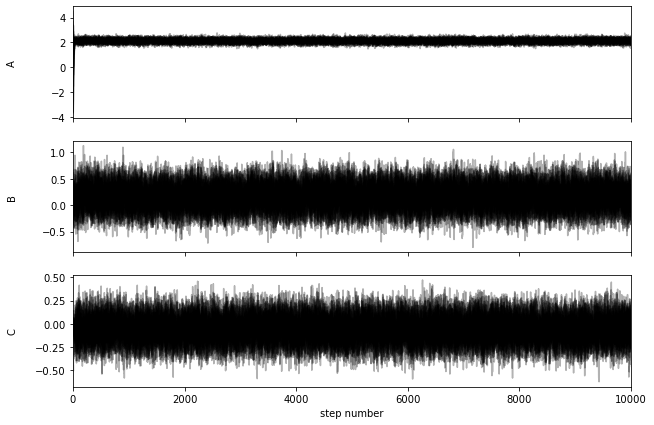

In [12]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['A', 'B', 'C']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [13]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

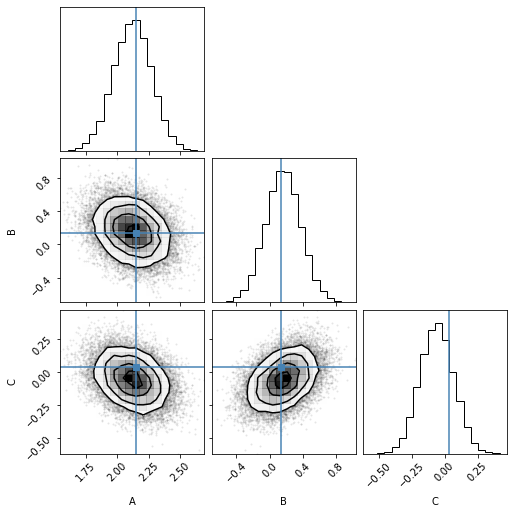

In [14]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[np.mean(AA_the), np.mean(BB_the), np.mean(CC_the)]
);

Empirical Measurements:
-----------------------
Estimate: 4.678202037726363 M_earth
Variance: 0.10527523502887974 M_earth^2
Standard Deviation: 0.3244614538414074 M_earth


Text(0, 0.5, 'Counts')

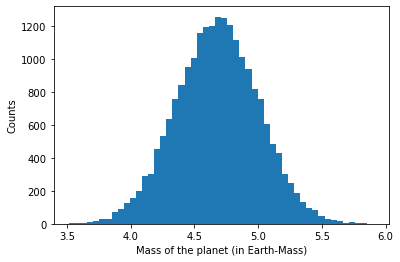

In [15]:
A_emcee = flat_samples[:,0]
B_emcee = flat_samples[:,1]

mass_emcee = mass(A_emcee, B_emcee)
mass_emcee1 = mass_emcee/5.972e+24
vari2_e = np.var(mass_emcee1)
stdd2_e = np.std(mass_emcee1)
print('Empirical Measurements:')
print('-----------------------')
print('Estimate: ' + str(np.mean(mass_emcee1)) + ' M_earth')
print('Variance: ' + str(vari2_e) + ' M_earth^2')
print('Standard Deviation: ' + str(stdd2_e) + ' M_earth')

plt.hist(mass_emcee1, bins=50)
plt.xlabel('Mass of the planet (in Earth-Mass)')
plt.ylabel('Counts')

## Estimates using emcee (Part 2: Initial Values are LS estimates)

In [16]:
nwalkers1, ndim1 = 32, 3

posInit1 = np.array([np.mean(AA_the), np.mean(BB_the), np.mean(CC_the)])*np.random.randn(nwalkers1, ndim1)

sampler1 = emcee.EnsembleSampler(nwalkers1, ndim1, log_prob)#, args=(time, rv, rve))
sampler1.run_mcmc(posInit1, 10000, progress=True)

100%|██████████| 10000/10000 [00:25<00:00, 396.06it/s]


State([[ 2.02872504e+00  2.42703370e-01  3.94973454e-02]
 [ 1.98858601e+00  3.55072755e-01  7.25009533e-03]
 [ 1.92151931e+00  8.50032205e-02 -4.67014671e-02]
 [ 2.36654626e+00 -1.29103381e-01  5.72160484e-02]
 [ 2.44402906e+00 -5.24726587e-02 -1.00604889e-01]
 [ 2.38086859e+00  1.24226624e-01 -1.51311921e-01]
 [ 2.32025465e+00  1.59781624e-01 -1.47074853e-01]
 [ 2.17570014e+00  2.79095100e-01 -2.58421156e-02]
 [ 1.91576183e+00  2.24941885e-01 -3.74829055e-02]
 [ 2.27649163e+00  2.09793512e-01  1.70166736e-02]
 [ 2.39935700e+00  7.98051452e-04 -1.67569151e-01]
 [ 2.11221953e+00 -1.25226038e-01  2.04076660e-01]
 [ 2.41004543e+00  1.50920547e-01 -3.58054019e-02]
 [ 1.92501530e+00 -3.23010546e-02 -8.55957863e-02]
 [ 2.02571899e+00 -7.94741384e-02 -1.78970024e-01]
 [ 2.14720159e+00  1.56910990e-01 -2.11246594e-01]
 [ 2.36427367e+00  3.78710275e-02  4.93292617e-03]
 [ 2.23610773e+00  5.48944648e-01  8.50265315e-02]
 [ 2.12200851e+00 -6.42986135e-02 -1.56328631e-01]
 [ 2.09686222e+00 -1.8643

In [17]:
tau1 = sampler1.get_autocorr_time()
print(tau1)

[36.19448408 37.18528811 42.1399146 ]


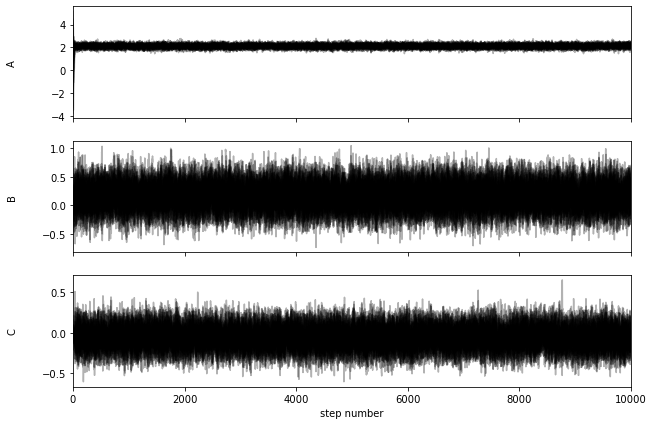

In [18]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples1 = sampler1.get_chain()
labels = ['A', 'B', 'C']
for i in range(ndim1):
    ax = axes[i]
    ax.plot(samples1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples1))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
flat_samples1 = sampler1.get_chain(discard=100, thin=15, flat=True)

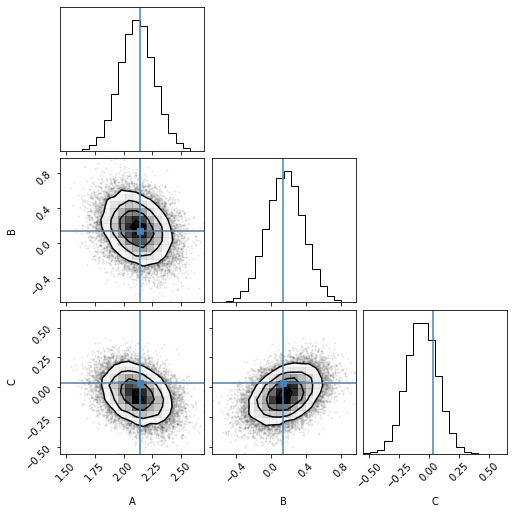

In [20]:
fig = corner.corner(
    flat_samples1, labels=labels, truths=[np.mean(AA_the), np.mean(BB_the), np.mean(CC_the)]
);

Empirical Measurements:
-----------------------
Estimate: 4.671990655660144 M_earth
Variance: 0.10469619585137988 M_earth^2
Standard Deviation: 0.32356791536148927 M_earth


Text(0, 0.5, 'Counts')

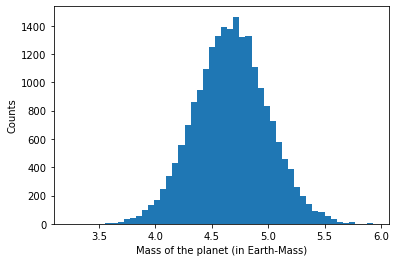

In [21]:
A_emcee1 = flat_samples1[:,0]
B_emcee1 = flat_samples1[:,1]

mass_emcee_LS = mass(A_emcee1, B_emcee1)
mass_emcee1_LS = mass_emcee_LS/5.972e+24
vari2_e = np.var(mass_emcee1_LS)
stdd2_e = np.std(mass_emcee1_LS)
print('Empirical Measurements:')
print('-----------------------')
print('Estimate: ' + str(np.mean(mass_emcee1_LS)) + ' M_earth')
print('Variance: ' + str(vari2_e) + ' M_earth^2')
print('Standard Deviation: ' + str(stdd2_e) + ' M_earth')

plt.hist(mass_emcee1_LS, bins=50)
plt.xlabel('Mass of the planet (in Earth-Mass)')
plt.ylabel('Counts')